In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('solvent.csv')
df

,solvent_smiles,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_priamide,fr_pyridine,fr_sulfide,fr_sulfone,fr_thiophene,fr_urea
0,CC(Cl)(Cl)Cl,6.520833,6.520833,2.145833,-2.516204,0.445171,23.400000,133.405,130.381,131.930033,...,0,0,0,0,0,0,0,0,0,0
1,CN(C)C(=O)N(C)C,11.841944,11.841944,0.723472,-3.530671,0.444130,37.000000,116.164,104.068,116.094963,...,0,0,0,0,0,0,0,0,0,1
2,CC(Cl)Cl,6.551698,6.551698,2.368056,-2.614969,0.405983,29.500000,98.960,94.928,97.969005,...,0,0,0,0,0,0,0,0,0,0
3,C=C(Cl)Cl,6.314815,6.314815,0.296296,-0.543210,0.432798,12.500000,96.944,94.928,95.953355,...,0,0,0,0,0,0,0,0,0,0
4,NCCN,6.875000,6.875000,0.510833,-3.031250,0.403496,45.500000,60.100,52.036,60.068748,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,CCCCCCCCCCCCO,7.983009,7.983009,3.423870,-4.832249,0.512982,53.230769,186.339,160.131,186.198365,...,0,0,0,0,0,0,0,0,0,0
344,CCCCCCCCCCCCCCCC,8.148258,8.148258,4.109026,-5.130312,0.314905,56.500000,226.448,192.176,226.266051,...,0,0,0,0,0,0,0,0,0,0
345,Cc1ccc(C(C)(C)C)cc1,7.958449,7.958449,1.058541,-3.796152,0.529305,37.454545,148.249,132.121,148.125201,...,0,0,0,0,0,0,0,0,0,0
346,CCC(C)OC(C)=O,11.195435,11.195435,2.169676,-3.892130,0.508859,45.500000,116.160,104.064,116.083730,...,0,0,0,0,0,0,0,0,0,0


# Data Standardization

In [3]:
from sklearn.preprocessing import StandardScaler

X = df.iloc[:, 1:].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine the Number of Clusters

In [4]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc
from sklearn.cluster import DBSCAN

In [5]:
def line_segment_distance(x, y, x_start, y_start, x_end, y_end):
    """
    计算点 (x, y) 到线段 (x_start, y_start) 和 (x_end, y_end) 的垂直距离。
    """
    # 线段向量
    seg_vec_x = x_end - x_start
    seg_vec_y = y_end - y_start
    
    # 点到线段起点的向量
    point_to_start_vec_x = x - x_start
    point_to_start_vec_y = y - y_start
    
    # 投影长度
    proj_length = (point_to_start_vec_x * seg_vec_x + point_to_start_vec_y * seg_vec_y) / (seg_vec_x**2 + seg_vec_y**2)
    
    # 投影点坐标
    proj_point_x = x_start + proj_length * seg_vec_x
    proj_point_y = y_start + proj_length * seg_vec_y
    
    # 检查投影点是否在线段上
    if proj_length < 0:
        proj_point_x, proj_point_y = x_start, y_start
    elif proj_length > 1:
        proj_point_x, proj_point_y = x_end, y_end
    
    # 计算垂直距离
    distance = np.sqrt((proj_point_x - x)**2 + (proj_point_y - y)**2)
    return distance

In [6]:
# 设置聚类迭代数
range_n_clusters = range(2, 50)

### Elbow Method

Best number of clusters based on Calinski-Harabasz Index: 14


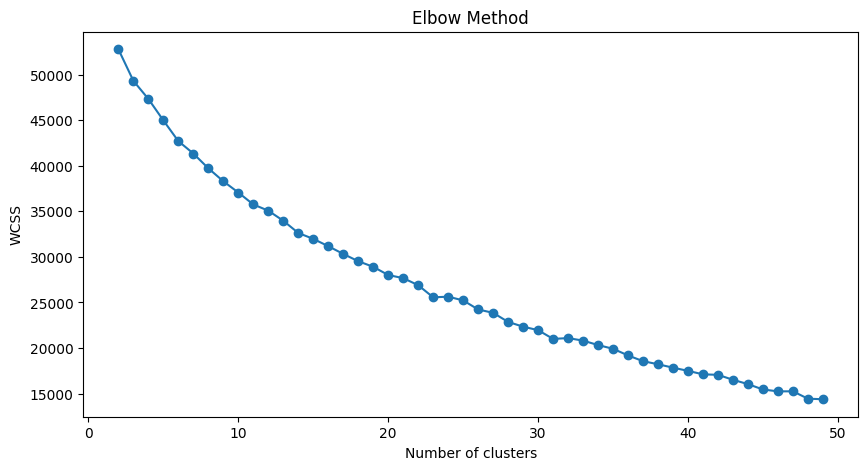

In [7]:
wcss = []  # 存储每个k值对应的总组内平方和
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)####
    wcss.append(kmeans.inertia_)  # inertia_是计算的WSS

# 使用Kneedle算法寻找肘点

x = np.array(list(range_n_clusters))
y = np.array(wcss)

# 获取线段的起点和终点
x_start, y_start = x[0], y[0]
x_end, y_end = x[-1], y[-1]

# 计算每个点到线段的距离
distances = [line_segment_distance(xi, yi, x_start, y_start, x_end, y_end) for xi, yi in zip(x, y)]
    
# 找到轮廓系数最高的簇数
best_n_clusters = range_n_clusters[np.argmax(distances)]
print(f"Best number of clusters based on Calinski-Harabasz Index: {best_n_clusters}")

plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Silhouette Method

Best number of clusters based on Calinski-Harabasz Index: 46


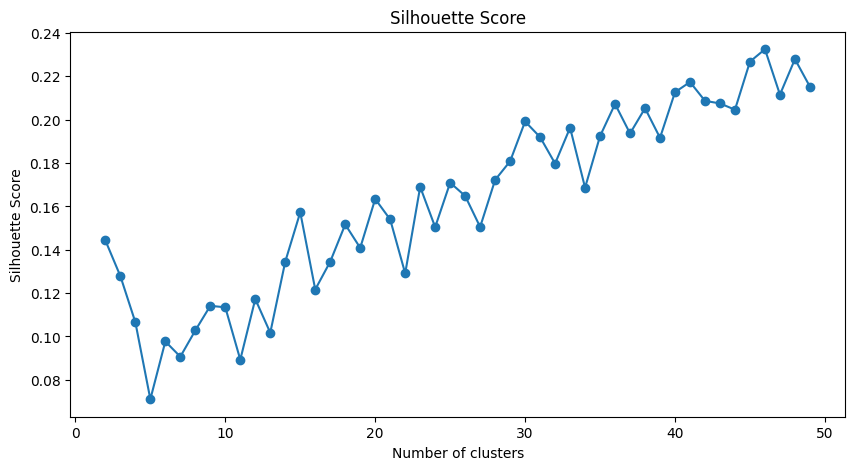

In [8]:
from sklearn.metrics import silhouette_score

silhouette_scores = []  # 存储每个k值对应的平均轮廓系数
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)####
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)####
    silhouette_scores.append(silhouette_avg)
    
# 找到轮廓系数最高的簇数
best_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Best number of clusters based on Calinski-Harabasz Index: {best_n_clusters}")

plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

###  Calinski-Harabasz Index Method

Best number of clusters based on Calinski-Harabasz Index: 3


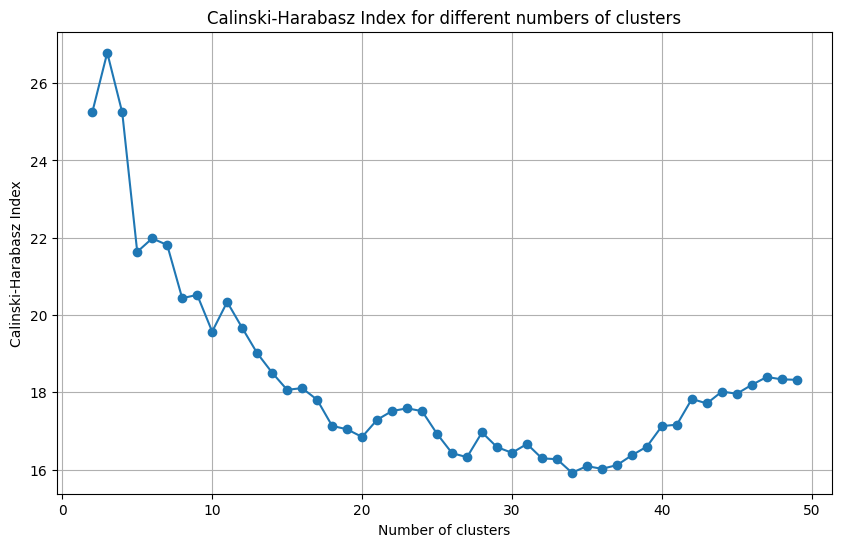

In [9]:
from sklearn.metrics import calinski_harabasz_score

# 初始化变量存储结果
calinski_harabasz_scores = []

# 迭代不同的簇数并计算Calinski-Harabasz指数
for n_clusters in range_n_clusters:
    kmeans_clustering = KMeans(n_clusters=n_clusters, random_state=0).fit(X_scaled)####
    clusters_agg = kmeans_clustering.fit_predict(X_scaled)####
    
    score = calinski_harabasz_score(X_scaled, clusters_agg)####
    calinski_harabasz_scores.append(score)

# 找到Calinski-Harabasz指数最高的簇数
best_n_clusters = range_n_clusters[np.argmax(calinski_harabasz_scores)]
print(f"Best number of clusters based on Calinski-Harabasz Index: {best_n_clusters}")

# 可视化结果
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, calinski_harabasz_scores, marker='o')
plt.title('Calinski-Harabasz Index for different numbers of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.grid(True)
plt.show()

### Comprehensive Calculation of the Final Number of Clusters

In [10]:
def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [11]:
normalized_wcss_distances = normalize(distances)
normalized_silhouette_scores = normalize(silhouette_scores)
normalized_calinski_harabasz_scores = normalize(calinski_harabasz_scores)

# 综合得分计算
combined_scores = normalized_wcss_distances + normalized_silhouette_scores + normalized_calinski_harabasz_scores
normalized_combined_scores = normalize(combined_scores)
# 找到综合得分最大的簇数
optimal_clusters = range_n_clusters[np.argmax(combined_scores)]

print(f'The optimal clusters number:{optimal_clusters}')

The optimal clusters number:23


In [12]:
df1 = pd.DataFrame(columns = ['n_clusters', 'normalized_combined_scores'])
df1['n_clusters'] = range_n_clusters
df1['normalized_combined_scores'] = normalized_combined_scores.round(2)

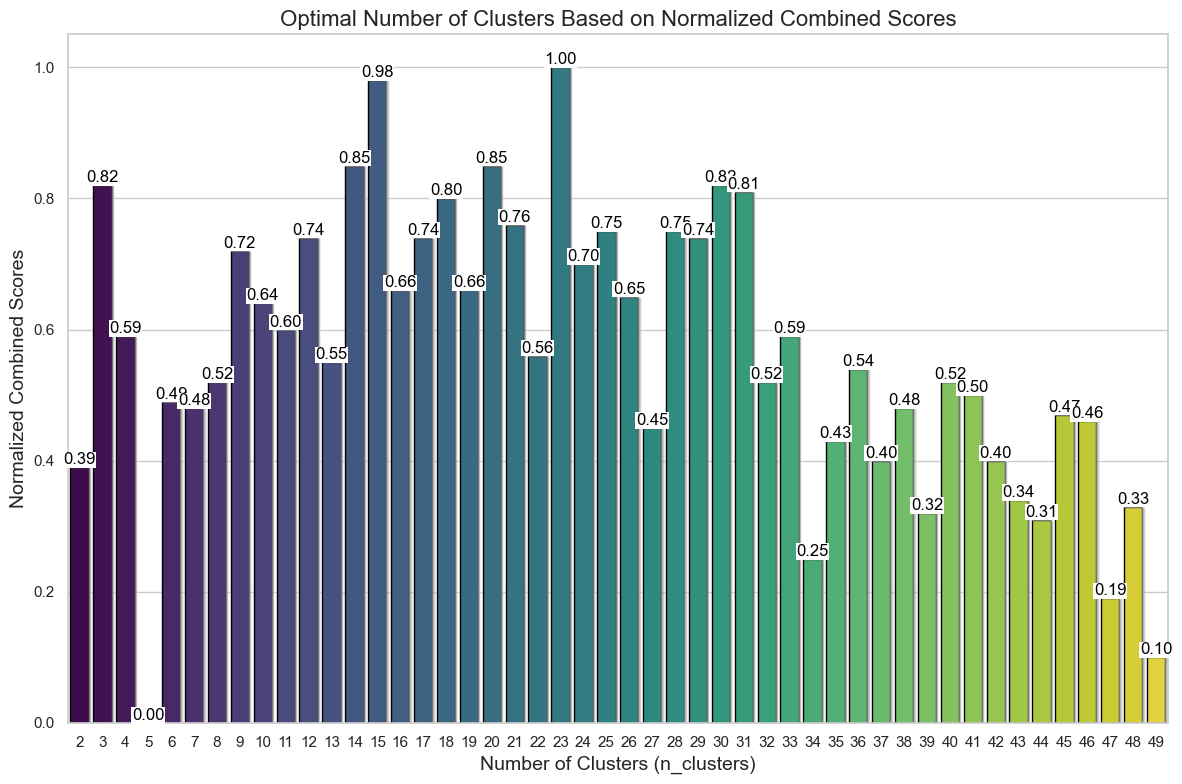

In [13]:
# 设置绘图风格
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# 绘制带有立体效果的柱状图
ax = sns.barplot(x='n_clusters', y='normalized_combined_scores', hue='n_clusters', data=df1, palette='viridis', edgecolor='black', legend=False)

# 添加阴影以增加立体感
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.add_patch(plt.Rectangle((left+width, bottom), 0.1, height, fill=True, facecolor='gray', alpha=0.4))
    ax.add_patch(plt.Rectangle((left, bottom+height), width, 0.005, fill=True, facecolor='gray', alpha=0.4))

# 设置标题和标签
plt.title('Optimal Number of Clusters Based on Normalized Combined Scores', fontsize=16)
plt.xlabel('Number of Clusters (n_clusters)', fontsize=14)
plt.ylabel('Normalized Combined Scores', fontsize=14)

# 添加数值标签到每个柱子上，并调整文本格式
bars = ax.patches  # 获取所有的柱子
for i, bar in enumerate(bars[:len(df1)]):  # 只遍历对应数据点数量的柱子
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', 
            ha='center', va='bottom', fontsize=12, color='black',
            bbox=dict(facecolor='white', edgecolor='none', pad=0.5))

# 调整布局并显示图形
plt.tight_layout()
plt.show()

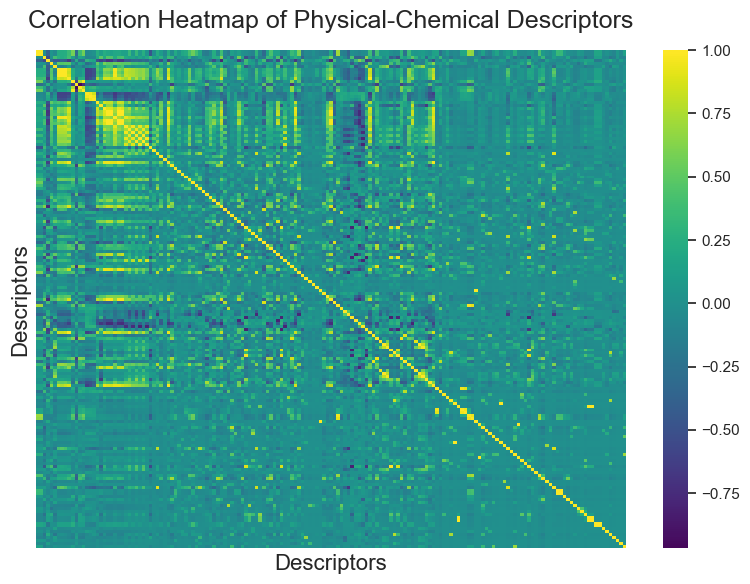

In [14]:
# 计算描述符间的皮尔逊相关系数矩阵
correlation_matrix = df.iloc[:, 1:].corr()

# 绘制热图
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, cmap='viridis', center=0, annot=False, 
            xticklabels=False, yticklabels=False)

# 设置标题和标签
plt.title('Correlation Heatmap of Physical-Chemical Descriptors', pad=16, fontsize=18)
plt.xlabel('Descriptors', fontsize=16)
plt.ylabel('Descriptors', fontsize=16)

# 调整布局以防止标签被裁剪
plt.tight_layout()

# 显示热图
plt.show()

# K-means Clustering and t-SNE Dimensionality Reduction Visualization

### K-means Clustering

In [15]:
from sklearn.cluster import KMeans

# 创建KMeans实例并拟合数据
kmeans = KMeans(n_clusters=23, random_state=0).fit(X_scaled)

# 获取聚类标签
labels = kmeans.labels_

### t-SNE Visualization

In [16]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)
tsne_df = pd.DataFrame(X_tsne, columns=['tsne_1', 'tsne_2'])
tsne_df['cluster'] = labels
tsne_df['label'] = ['Unknown']*df.shape[0]
tsne_df['solvent_smiles'] = df['solvent_smiles']
tsne_df.loc[12, 'label'] = 'Good'
tsne_df.loc[119, 'label'] = 'Good'
tsne_df.loc[1, 'label'] = 'Good'
tsne_df.loc[86, 'label'] = 'Bad'
tsne_df.loc[60, 'label'] = 'Bad'

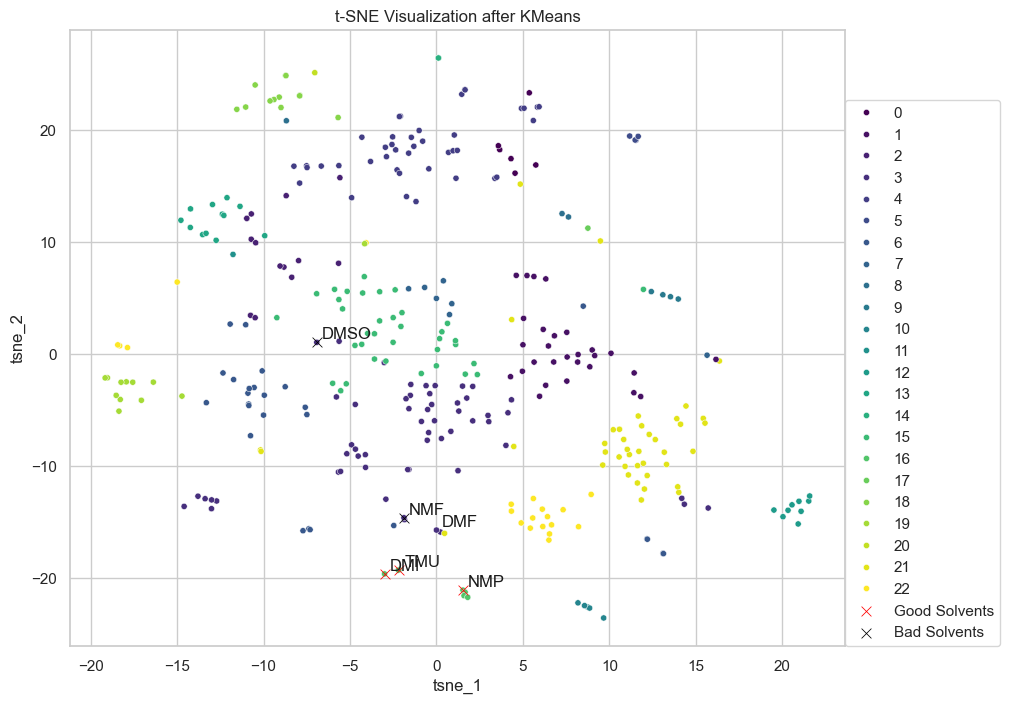

In [17]:
# 可视化 t-SNE 结果
# 绘制所有未知数据点（灰色）
# sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_df[tsne_df['label'] == 'Unknown'], color='gray', label='Unknown')

# 设置绘图风格和尺寸
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

# 绘制所有数据点，基于 'cluster' 列的不同值进行着色
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_df, hue='cluster', palette='viridis', s=20, legend='full')

# 绘制已知的好数据点（绿色）
good_points = tsne_df[tsne_df['label'] == 'Good']
sns.scatterplot(x='tsne_1', y='tsne_2', data=good_points, color='red', marker='x', s=50, label='Good Solvents')

# 绘制已知的坏数据点（红色）
bad_points = tsne_df[tsne_df['label'] == 'Bad']
sns.scatterplot(x='tsne_1', y='tsne_2', data=bad_points, color='black', marker='x', s=50, label='Bad Solvents')

# 添加特定数据点的信息标签
labels = ['NMP', 'DMI', 'TMU', 'NMF', 'DMSO', 'DMF']
indices = [12, 119, 1, 86, 60, 79]
for i, label in zip(indices, labels):
    plt.text(tsne_df.iloc[i, 0]+0.3, tsne_df.iloc[i, 1]+0.3, label, color='k')

plt.title('t-SNE Visualization after KMeans')
plt.legend(loc=(1,0))
plt.show()

# Further Analysis Combining Experiments

### GOOD：N-Methylpyrrolidone(NMP-12), 1,3-Dimethyl-2-imidazolidinone(DMI-119), Tetramethylurea(TMU-1)
### BAD：N-Methylformamide(NMF-86), Dimethyl sulfoxide(DMSO-60)

In [18]:
from pubchempy import get_compounds
from rdkit import Chem

In [19]:
tsne_df[tsne_df['cluster']== 16]

,tsne_1,tsne_2,cluster,label,solvent_smiles
1,-2.139782,-19.222141,16,Good,CN(C)C(=O)N(C)C
12,1.534041,-21.045443,16,Good,CN1CCCC1=O
118,-2.202968,-19.262699,16,Unknown,CN1CCCN(C)C1=O
119,-3.000138,-19.599472,16,Good,CN1CCN(C)C1=O
120,1.658954,-21.229017,16,Unknown,CCN1CCCC1=O
149,1.595763,-21.540155,16,Unknown,CN1CCCCCC1=O
314,1.811192,-21.685707,16,Unknown,C=CN1CCCCCC1=O


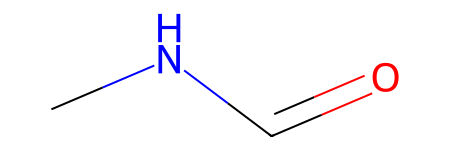

In [20]:
TMU_1 = 'CN(C)C(=O)N(C)C'
NMP_12 = 'CN1CCCC1=O'
DMPU_118 = 'CN1CCCN(C)C1=O'
DMI_119 = 'CN1CCN(C)C1=O'
NEP_120 = 'CCN1CCCC1=O'
N_Methylcaprolactam_149 = 'CN1CCCCCC1=O'
N_Vinylcaprolactam_314 = 'C=CN1CCCCCC1=O'
DMSO_60 = 'CS(C)=O'
NMF_86 = 'CNC=O'
Chem.MolFromSmiles(NMF_86)

# Integrate Compound Experimental Feature Data

In [21]:
df1 = pd.read_csv('solvent_extra.csv')
df2 = pd.concat([df, df1.iloc[:,1:]], axis=1)

### Set Data Labels Based on Experimental Results

In [22]:
df2['label'] = [-1]*348
df2.loc[1, 'label'] = 1
df2.loc[12, 'label'] = 1
df2.loc[119, 'label'] = 1
df2.loc[120, 'label'] = 0
df2.loc[60, 'label'] = 0
df2.loc[86, 'label'] = 0

### Preliminary Model Evaluation

In [23]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

# 划分特征向量和标签（排除首列ID和末列标签）
X = df2.iloc[:, 1:-1].values  # 特征矩阵
y = df2['label'].values       # 标签向量

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分带标签数据
X_labeled = X_scaled[y != -1]
y_labeled = y[y != -1]

# 初始化5折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 存储每个折叠的结果
all_models = []
all_predictions = []

for train_index, test_index in kf.split(X_labeled):
    X_train, X_test = X_labeled[train_index], X_labeled[test_index]
    y_train, y_test = y_labeled[train_index], y_labeled[test_index]

    # 使用LazyPredict进行模型训练和评估
    clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit(X_train, X_test, y_train, y_test)
    
    all_models.append(models)
    all_predictions.append(predictions)

  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 3
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 4, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250000 -> initscore=-1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because ther

  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 3, number of negative: 2
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 5, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there 

  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 3, number of negative: 2
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 5, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there 

  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 2, number of negative: 3
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 5, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400000 -> initscore=-0.405465
[LightGBM] [Info] Start training from score -0.405465
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because ther

  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 3, number of negative: 2
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 5, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there 

### Instantiate High-Performance Model

In [24]:
# 初始化一个空集合来存储模型名称
models_name = set()

# 遍历每个折叠的最佳模型
for model in all_models:
    # 找到准确率为 1 的模型名称
    perfect_models = model[model['Accuracy'] == 1].index
    
    # 将找到的模型名称添加到集合中
    for model_name in perfect_models:
        models_name.add(model_name)

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.utils import all_estimators
from sklearn.base import ClassifierMixin
from tqdm import tqdm
import inspect

In [26]:
def train_and_evaluate_model(model_name, X_train, y_train, X_test, y_test, random_state=42, ignore_warnings=True):
    """
    根据给定的模型名称训练模型，并输出评估指标。

    参数:
    - model_name: 模型名称 (如 'LogisticRegression')
    - X_train, y_train: 训练数据和标签
    - X_test, y_test: 测试数据和标签
    - random_state: 随机状态种子
    - ignore_warnings: 是否忽略警告信息

    返回:
    - trained_model: 训练好的模型
    - metrics: 包含准确率、分类报告和混淆矩阵的字典
    """
    
    # 定义需要移除的分类器
    removed_classifiers = [
        "ClassifierChain",
        "ComplementNB",
        "GradientBoostingClassifier",
        "GaussianProcessClassifier",
        "HistGradientBoostingClassifier",
        "MLPClassifier",
        "LogisticRegressionCV", 
        "MultiOutputClassifier", 
        "MultinomialNB", 
        "OneVsOneClassifier",
        "OneVsRestClassifier",
        "OutputCodeClassifier",
        "RadiusNeighborsClassifier",
        "VotingClassifier",
    ]
    
    # 获取所有分类器
    classifiers = [
        est for est in all_estimators()
        if (issubclass(est[1], ClassifierMixin) and (est[0] not in removed_classifiers))
    ]
    
    # 将分类器转换为字典形式
    classifier_dict = {clf[0]: clf[1] for clf in classifiers}
    
    # 如果给定的模型名称不在分类器字典中，则抛出异常
    if model_name not in classifier_dict:
        raise ValueError(f"Model '{model_name}' is not available.")
    
    # 转换输入数据为 DataFrame（如果它们是 NumPy 数组）
    if isinstance(X_train, np.ndarray):
        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)

    numeric_features = X_train.select_dtypes(include=[np.number]).columns
    categorical_features = X_train.select_dtypes(include=["object"]).columns

    # 定义数值和分类特征的预处理器
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
    )

    categorical_transformer_low = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("encoding", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ]
    )

    categorical_transformer_high = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("encoding", OrdinalEncoder()),
        ]
    )

    def get_card_split(df, cols, n=11):
        cond = df[cols].nunique() > n
        card_high = cols[cond]
        card_low = cols[~cond]
        return card_low, card_high

    categorical_low, categorical_high = get_card_split(X_train, categorical_features)

    preprocessor = ColumnTransformer(
        transformers=[
            ("numeric", numeric_transformer, numeric_features),
            ("categorical_low", categorical_transformer_low, categorical_low),
            ("categorical_high", categorical_transformer_high, categorical_high),
        ]
    )

    # # 创建并训练模型
    ModelClass = classifier_dict[model_name]
    model_params = {}
    
    # 检查模型是否接受 random_state 参数
    if 'random_state' in inspect.signature(ModelClass).parameters:
        model_params['random_state'] = random_state
    
    model = ModelClass(**model_params)
    
    pipe = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", model)]
    )
    
    pipe.fit(X_train, y_train)
    
    # 预测
    y_pred = pipe.predict(X_test)
    
    # 计算评估指标
    accuracy = accuracy_score(y_test, y_pred)
    b_accuracy = balanced_accuracy_score(y_test, y_pred)
    
    # 返回训练好的模型和评估指标
    metrics = {
        "Accuracy": accuracy,
        "Balanced Accuracy": b_accuracy
    }
    
    return pipe, metrics

In [27]:
# 初始化留一法交叉验证
loo = LeaveOneOut()

# 存储所有找到的准确率为 1 的模型及其评估指标
all_models = {}
all_metrics = {}

fold = 0
for train_index, test_index in loo.split(X_labeled):
    fold += 1
    print(f"\n正在处理第 {fold} 折交叉验证（留一法）...")
    
    X_train, X_test = X_labeled[train_index], X_labeled[test_index]
    y_train, y_test = y_labeled[train_index], y_labeled[test_index]
    
    for model_name in tqdm(models_name, desc='模型训练中：'):
        try:
            trained_model, metrics = train_and_evaluate_model(model_name, X_train, y_train, X_test, y_test)
            
            if metrics['Accuracy'] == 1:
                # 在模型名称中添加当前交叉验证的折数（即测试样本编号）
                model_name_with_fold = f"{model_name}_sample_{fold}"
                all_models[model_name_with_fold] = trained_model
                all_metrics[model_name_with_fold] = metrics
                
        except Exception as e:
            print(f"模型 {model_name} 在第 {fold} 折训练时出错：{e}")


正在处理第 1 折交叉验证（留一法）...


模型训练中：: 100%|██████████| 20/20 [00:01<00:00, 11.03it/s]



正在处理第 2 折交叉验证（留一法）...


模型训练中：: 100%|██████████| 20/20 [00:01<00:00, 10.41it/s]



正在处理第 3 折交叉验证（留一法）...


模型训练中：: 100%|██████████| 20/20 [00:01<00:00, 10.69it/s]



正在处理第 4 折交叉验证（留一法）...


模型训练中：: 100%|██████████| 20/20 [00:01<00:00, 11.17it/s]



正在处理第 5 折交叉验证（留一法）...


模型训练中：: 100%|██████████| 20/20 [00:01<00:00, 11.07it/s]



正在处理第 6 折交叉验证（留一法）...


模型训练中：: 100%|██████████| 20/20 [00:01<00:00, 10.82it/s]


In [28]:
prediction = []
for sol in tqdm(X_scaled, desc='预测未知溶剂中：'):
    count = 0
    for model in all_models.values():
        predict_label = model.predict(sol.reshape(1, -1))
        if predict_label[0] == 1:
            count += 1
    pro = round(count/len(all_models), 4)
    prediction.append(pro)

预测未知溶剂中：: 100%|██████████| 348/348 [00:47<00:00,  7.32it/s]
